In [2]:
# !git clone https://github.com/Wayn-Git/CatvsDog

In [3]:
# %cd CatvsDog

# Importing Libraries

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import seaborn as sns

## Assigning the Directory

In [5]:
train_dir = "../Data/train"
test_dir = "../Data/test"

## Making a train and test generator 

In [6]:


trainGen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
testGen = ImageDataGenerator(rescale=1./255)


train_gen = trainGen.flow_from_directory(train_dir,
                                          target_size=(160,160), 
                                          batch_size=64,
                                            class_mode="binary")
test_gen = testGen.flow_from_directory(test_dir,
                                        batch_size=64 ,
                                        target_size=(160,160), 
                                        class_mode="binary")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## Checking the number of samples 

In [7]:
print("training samples:", train_gen.samples)
print("test samples:", test_gen.samples)
print("class indices:", train_gen.class_indices)

training samples: 8005
test samples: 2023
class indices: {'cats': 0, 'dogs': 1}


In [8]:
## Initializing the model. Using Tranfer Learning for better training

In [9]:
TRANSFER_LEARNING = True

if TRANSFER_LEARNING:
    print("Creating Transfer Learning model with MobileNetV2...")

    base_model = MobileNetV2(
        input_shape=(160, 160, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False 

    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
else:
    print("Creating Lightweight Custom CNN...")

    model = models.Sequential([
        layers.Input(shape=(160,160,3)),

        Conv2D(16 , (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), activation = 'relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        GlobalAveragePooling2D(),

        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])


Creating Transfer Learning model with MobileNetV2...


## Compiling the Model

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Displaying the model summary

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Early stopping to avoid over fitting and useless epochs

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## Reduce Lr to make sure that the model learns (Slows down the model so it learns)

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.2,           
    patience=3,           
    min_lr=1e-7,           
    verbose=1             
)

## Initizalizing a callbacks variable

In [14]:
callbacks = [early_stopping, reduce_lr]

## Actual Training of the model

In [15]:
history = model.fit(train_gen,
                    epochs=30,
                    validation_data=test_gen,
                    verbose=1,
                    callbacks=callbacks,
                    steps_per_epoch=train_gen.samples // train_gen.batch_size,
                    validation_steps=test_gen.samples // test_gen.batch_size)

c:\Users\bilal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8988 - loss: 0.2262 - val_accuracy: 0.9753 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 2/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:30 729ms/step - accuracy: 0.9844 - loss: 0.0938

c:\Users\bilal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step - accuracy: 0.9844 - loss: 0.0938 - val_accuracy: 0.9763 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9622 - loss: 0.0978 - val_accuracy: 0.9713 - val_loss: 0.0680 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.9531 - loss: 0.0900 - val_accuracy: 0.9718 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.9640 - loss: 0.0917
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9640 - loss: 0.0918 - val_accuracy: 0.9793 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9844 - loss: 0.0423 - val_accuracy: 0.9778 - val_loss: 0.0678 - learning_rate: 2.0000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9704 - loss: 0

## Displaying the Accuracy and Lose

In [16]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - accuracy: 0.9746 - loss: 0.0725
Test Accuracy: 0.9783
Test Loss: 0.0675


## Visual Representation of the train accuracy, val accuracy, Train Lose and Val Lose (Val = Test)


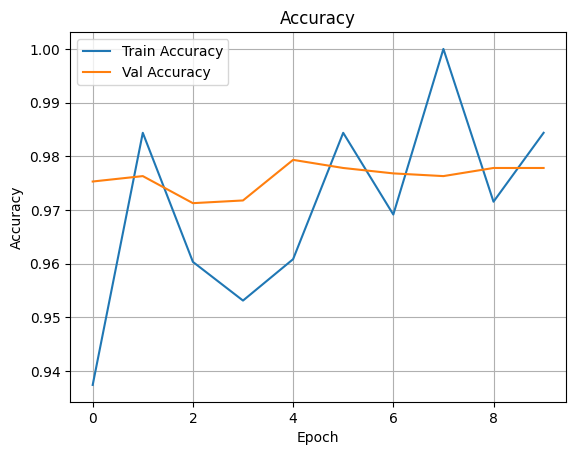

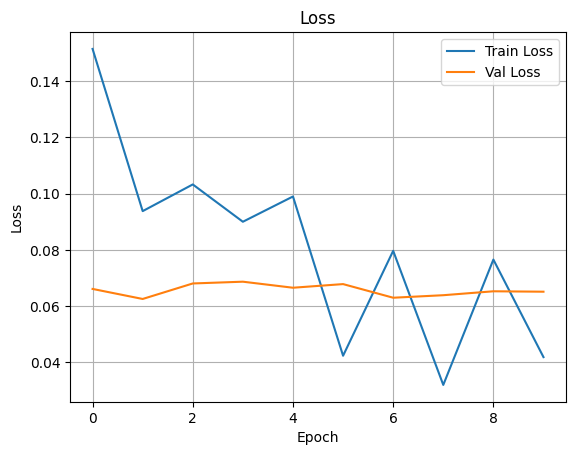

In [17]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


### (Was used in collab)

In [18]:
# import os
# os.makedirs("model", exist_ok=True)

### (Was used in collab)

In [21]:
model.save("../Model/cat_dog_model.keras")

## Predicting to see if it works

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "../Data/test/cats/cat.4024.jpg"
img = image.load_img(img_path, target_size=(160, 160))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Predicted: Dog 🐶")
else:
    print("Predicted: Cat 🐱")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
Predicted: Cat 🐱
